# Hierarchical Risk Parity Portfolio Optimization

In 2016, Dr. Marcos Lopez de Prado introduced the Hierarchical Risk Parity (HRP) algorithm for portfolio optimization. Prior to this, Harry Markowitz's Modern Portfolio Theory (MPT) was used as an industry-wide benchmark for portfolio optimization. MPT was an amazing accomplishment in the field of portfolio optimization and risk management, earning Harry Markowitz a nobel prize for his work. Although, there are some issues with traditional MPT algorithms and its translation to real-world investing. While MPT is mathematically sound, it fails to produce optimal portfolios which can perform in real-world scenarios. This can be mainly attributed to two different reasons:
1. MPT involves the estimation of returns for a given set of assets. Although, accurately estimating returns for a set of assets is very difficult, in which small errors in estimation can cause sub-optimal performance.
2. MPT optimization methods involve the inversion of a covariance matrix for a set of assets. This matrix inversion leads the algorithm to be susceptible to market volatility and can heavily change the results for small changes in the correlations.

The HRP algorithm aims to solve some of these issues with a new approach based on the notion of hierarchy. This algorithm is computed in three main steps:
1. Hierarchical Clustering - breaks down our assets into hierarchical clusters
2. Quasi-Diagonalization - reorganizes the covariance matrix, placing similar assets together
3. Recursive Bisection - weights are assigned to each asset in our portfolio

Throughout this post, we will explore the intuition behind this HRP algorithm and also learn to apply it through the MlFinLab libray. **Please keep in mind that this is a tutorial styled post and if you would like to learn more about the theory behind this algorithm, please refer to __[this article](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__**.

## How HRP Portfolio Optimization Works?

In this section, we will go through each step of the HRP algorith. We will explain the intution behind each step as well as show their implementation through code in the next section.

### Hierarchical Clustering
Hierarchical clustering is used to place our assets into clusters suggested by the data and not by previously defined metrics. This ensures that the assets in a specific cluster maintain similarity. The objective of this step is to build a hierarchical tree in which our assets are all clustered on different levels. Conceptually, this may be difficult for some to understand, which is why we can visualize this tree through a dendrogram.

<img src='dendrogram.png'/>

The previous image shows the hierarchical clustering process results through a dendrogram. As the square containining our assets A-F showcases the similarity between each other, we can understand how the assets are clustered. Keep in mind that we are using agglomerative clustering, which assumes each data point to be an individual cluster at the start. 

First, the assets E and F are clustered together as they are the most similar. This is followed by the clustering of assets A and B. From this point, the clustering algorithm then includes asset D (and subsequently asset C) into the first clustering pair of assets E and F. Finally, the asset pair A and B is then clustered with the rest of the assets in the last step.

So you now may be asking, how does the algorithm know which assets to cluster together? Of course, we can visually see the distance between each asset, but our algorithm cannot. There are a few widely used methods for calculating the measure of distance/similarity within our algorithm: 
1. **Single Linkage** - the distance between two clusters it the minimum distance between any two points in the clusters
2. **Complete Linkage** - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. **Average Linkage** - the distance between two clusters is the average of the distance between any two points in the clusters
4. **Ward Linkage** - the distance between two clusters is the increase of the squared error from when two clusters are merged

Thankfully, we can easily implement each linkage algorithm within the MlFinLab library, allowing us to quickly compare the results to each other.

### Quasi-Diagonalization

Once our assets are all clustered into a hierarchical tree, we can now perform our quasi-diagonalization step in our algorithm. From our previous step, we clustered all our assets into a hierarchical tree based on similarity defined through our chosen distance measure. In this step, we rearrange the rows and columns of the covariance matrix of assets so that we place similar assets together and dissimilar assets further apart. Once completed, this step rearranges our covariance matrix in a way so that the larger covariances in our matrix are placed along the diagonal, with the smaller ones spread around this diagonal. Because the off-diagonal elements are not completely zero, this is called our quasi-diagonal covariance matrix.
<table><tr>
<td><img src='unclustered.png' /> Unclustered Covariance Matrix</td>
<td><img src='clustered.png' /> Clustered Covariance Matrix</td>
</tr></table>

From the images shown above, we can see how the unclustered matrix shows asset clusters in small sub-sections of our matrix, while after quasi-diagonalization our clustering structure becomes much more visible.

At this point in our algorithm, all of our assets have been clustered in a hierarchical tree and our covariance matrix has been rearranged accordingly.

### Recursive Bisection
Recursive bisection is the final and most important step in our algorithm. In this step, the actual portfolio weights are assigned to our assets in a top-down recursive manner.

At the end of our first step, we were left with our large hierarchical tree with one giant cluster and subsequent clusters nested within each other. By performing this step, we break each cluster into sub-clusters by starting with our largest cluster and moving down our tree in a top-down manner. Recursive bisection makes use of our quasi-diagonalized covariance matrix for recursing into the clusters under the assummption that for a diagonal matrix, the inverse-variance allocation is the most optimal allocation.

One of the main advantages to having this step in our algorithm is that our assets are only competing for weight allocation within the same cluster, leading us to developing a much more robust portfolio.

## Application + Results
In this section, we will go through a working example of how we can implement the HRP algorithm through the MlFInLab library. First we must laod in our required libraries and our data.

In [1]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity

In this example, we will be working with historical closing-price data for 17 assets. The data we are working with was chosen because the clustering structure is clearly visible so it is a very good dataset for working with and visualizing various clustering techniques.

In [2]:
# reading in our data
raw_prices = pd.read_csv('assetalloc.csv', sep=';', parse_dates=True, index_col='Dates')
stock_prices = raw_prices.sort_values(by='Dates')
stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-01-02,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67
1989-01-03,2021.3,859.83,287.11,384.25,97.703,97.017,96.441,93.833,99.374,98.584,98.410,97.990,154.67,116.57,1696.35,142.080,286.00
1989-01-05,2118.0,900.64,309.12,378.25,98.253,99.113,99.275,97.634,99.715,99.561,99.965,99.950,164.29,127.22,1737.26,184.354,283.30
1989-01-06,2103.4,924.65,321.97,362.00,97.643,98.640,98.788,96.555,100.488,101.549,103.140,104.156,172.40,129.53,1724.29,187.731,279.96
1989-01-08,2292.3,1006.38,343.75,368.75,98.506,100.479,102.162,102.822,102.457,106.041,108.903,113.106,174.21,134.62,1775.39,173.067,277.31


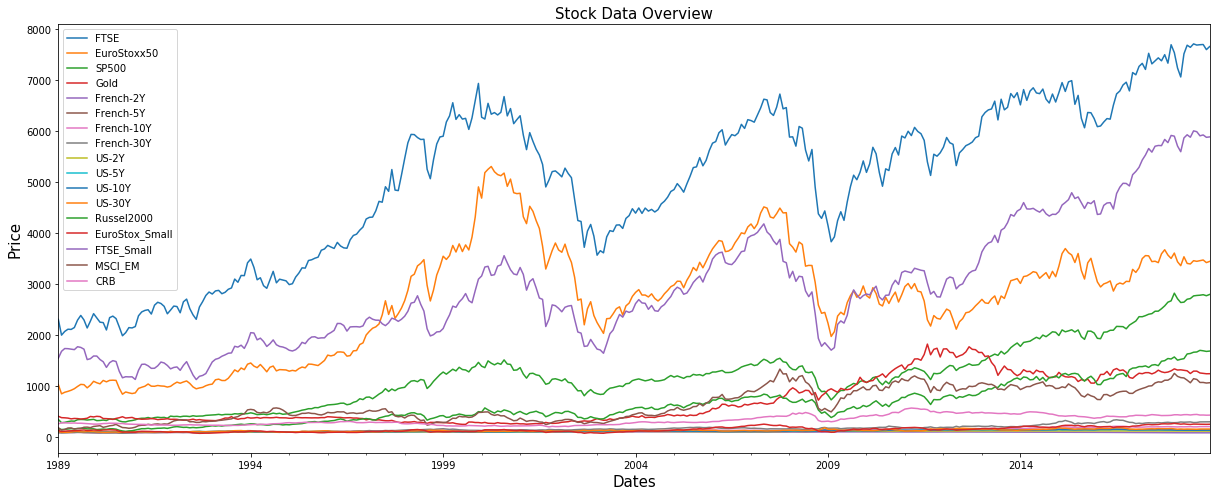

In [3]:
# taking a quick look at our data
stock_prices.resample('M').last().plot(figsize=(17,7))
plt.ylabel('Price', size=15)
plt.xlabel('Dates', size=15)
plt.title('Stock Data Overview', size=15)
plt.tight_layout()
plt.savefig('stock_overview')
plt.show()

Now that we have our data loaded in, we can make use of the HierarchicalRiskParity class from MlFinLab to construct our optimal portfolio. First we must instantiate our class and then run the allocate() method to optimize our portfolio.

The allocate method requires only two parameters to run its default solution:
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)

Users are also given the option to customize many different parameters in the allocate() method, some of these include:
1. The type of linkage algorithm being used
2. Whether to shrink the covariance matrix

MlFinLab currently supports all four linkage algorithms discussed in this post, although the default method is set as the Single Linkage algorithm.

Additionally, instead of providing raw historical closing prices, users can choose to input asset returns, a covariance matrix, and a distance matrix instead. For now, we will only be working with the two required parameters as well as specifying our linkage algorithm of choice.

In [4]:
# constructing our HRP portfolio - Single Linkage
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names=stock_prices.columns,
             asset_prices=stock_prices,
             linkage='single')

print("HRP Portfolio Weights\n", hrp.weights)

HRP Portfolio Weights
       US-2Y    US-30Y     US-5Y    US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.358167  0.007919  0.038605  0.015194   0.420506   0.094539    0.028567   

   French-30Y      Gold       CRB   MSCI_EM     SP500  Russel2000      FTSE  \
0    0.008817  0.005539  0.009072  0.001307  0.003914    0.001683  0.003048   

   FTSE_Small  EuroStoxx50  EuroStox_Small  
0    0.001498     0.000864        0.000761  


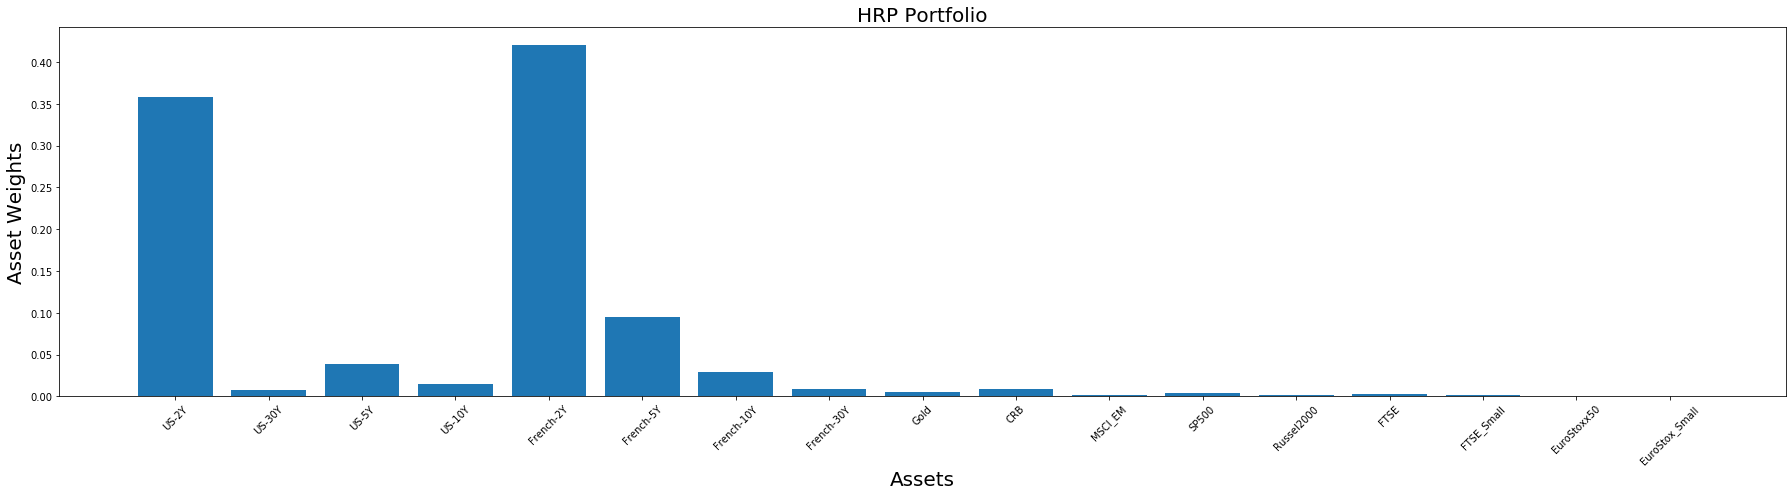

In [6]:
# plotting our optimal portfolio
hrp_weights = hrp.weights
y_pos = np.arange(len(hrp_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_weights.columns), hrp_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Portfolio Weights')
plt.show()

Now that we can implement our HRP algorithm, lets start to explore some of the additional functionality provided through the MlFinLab library.

We can make use of the plot_clusters() method to plot our produced dendrogram from our optimal portfolio.

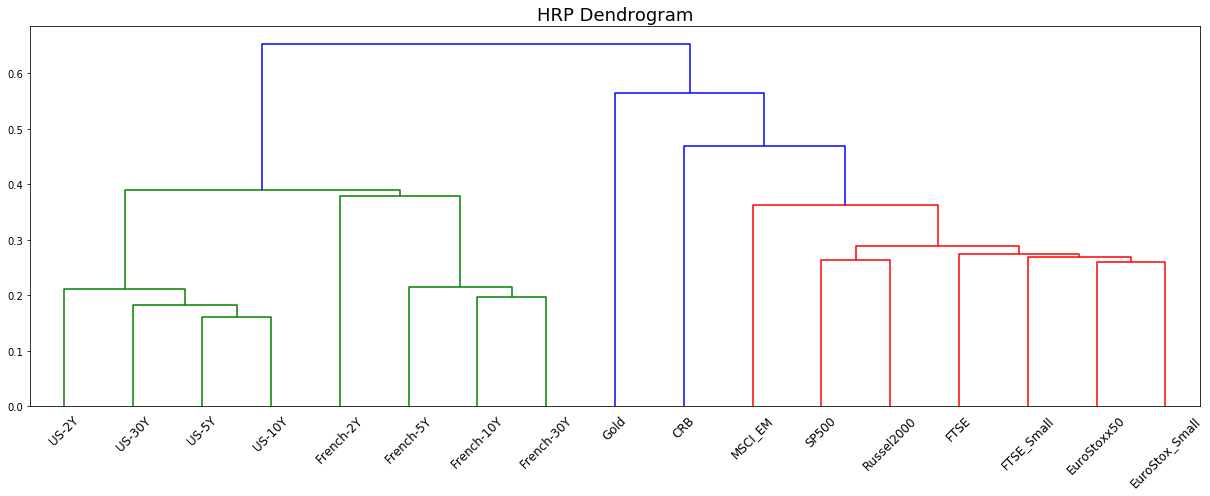

In [8]:
# plotting dendrogram of HRP portfolio
plt.figure(figsize=(17,7))
hrp.plot_clusters(stock_prices.columns)
plt.title('HRP Dendrogram', size=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('HRP Dendrogram')
plt.show()

In this graph, the different colours of the tree structure represent the clusters that the stocks belong to.

### Using Custom Input with MlFinLab
MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for assets, users can instead input asset returns, a covariance matrix of asset returns, a distance matrix, and side weights.

In this section, we will make use of the following parameters in the allocate() method to construct a custom use case:
1. asset_returns – (pd.Dataframe/numpy matrix) User supplied matrix of asset returns
2. covariance_matrix – (pd.Dataframe/numpy matrix) User supplied covariance matrix of asset returns
3. side_weights – (pd.Series/numpy matrix) With asset_names in index and value 1 for Buy, -1 for Sell (default 1 for all)

We will be constructing our first custom portfolio using the asset_returns and covariance_matrix parameters. We will then work with the side_weights parameter to construct a Long/Short portfolio.

To make some of the necessary calculations, we will make use of the ReturnsEstimators class provided by MlFinLab.

In [10]:
# importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimators

In [11]:
# calculating our asset returns
returns = ReturnsEstimators.calculate_returns(stock_prices)
returns.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-01-03,-0.009021,-0.017865,-0.033593,-0.021019,-0.013908,-0.020416,-0.031445,-0.061670,-0.006568,-0.017549,-0.026415,-0.038711,0.001878,-0.007915,0.036528,0.063600,-0.002337
1989-01-05,0.047840,0.047463,0.076661,-0.015615,0.005629,0.021604,0.029386,0.040508,0.003431,0.009910,0.015801,0.020002,0.062197,0.091361,0.024116,0.297537,-0.009441
1989-01-06,-0.006893,0.026659,0.041570,-0.042961,-0.006208,-0.004772,-0.004906,-0.011051,0.007752,0.019968,0.031761,0.042081,0.049364,0.018158,-0.007466,0.018318,-0.011790
1989-01-08,0.089807,0.088390,0.067646,0.018646,0.008838,0.018644,0.034154,0.064906,0.019594,0.044235,0.055876,0.085929,0.010499,0.039296,0.029635,-0.078112,-0.009466
1989-01-09,0.050255,0.034281,0.029033,-0.026441,-0.004233,-0.006559,-0.006392,-0.014802,-0.014816,-0.025999,-0.029981,-0.036629,0.025831,0.048953,-0.004788,0.029382,-0.000288


In [12]:
# calculating our covariance matrix
cov = returns.cov()
cov

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
FTSE,0.001792,0.002042,0.001628,0.000102,-0.000030,0.000012,0.000065,0.000097,-0.000043,-0.000090,-0.000113,-0.000201,0.001872,0.001904,0.001928,0.002283,0.000461
EuroStoxx50,0.002042,0.003230,0.002128,-0.000039,-0.000053,-0.000037,0.000013,0.000037,-0.000093,-0.000210,-0.000283,-0.000444,0.002436,0.002977,0.002567,0.002999,0.000564
SP500,0.001628,0.002128,0.002135,0.000055,-0.000058,-0.000010,0.000046,0.000035,-0.000038,-0.000085,-0.000109,-0.000231,0.002265,0.001967,0.001961,0.002508,0.000598
Gold,0.000102,-0.000039,0.000055,0.001774,-0.000011,0.000012,0.000024,0.000021,0.000026,0.000082,0.000113,0.000104,0.000125,0.000246,0.000183,0.001070,0.000501
French-2Y,-0.000030,-0.000053,-0.000058,-0.000011,0.000025,0.000037,0.000042,0.000058,0.000011,0.000024,0.000034,0.000053,-0.000066,-0.000081,-0.000067,-0.000093,-0.000048
French-5Y,0.000012,-0.000037,-0.000010,0.000012,0.000037,0.000111,0.000171,0.000262,0.000030,0.000079,0.000129,0.000209,-0.000037,-0.000085,-0.000050,-0.000111,-0.000076
French-10Y,0.000065,0.000013,0.000046,0.000024,0.000042,0.000171,0.000319,0.000530,0.000047,0.000137,0.000244,0.000423,-0.000003,-0.000049,-0.000027,-0.000121,-0.000117
French-30Y,0.000097,0.000037,0.000035,0.000021,0.000058,0.000262,0.000530,0.001034,0.000072,0.000228,0.000427,0.000795,-0.000036,-0.000072,-0.000090,-0.000278,-0.000248
US-2Y,-0.000043,-0.000093,-0.000038,0.000026,0.000011,0.000030,0.000047,0.000072,0.000028,0.000062,0.000084,0.000115,-0.000065,-0.000120,-0.000108,-0.000100,-0.000036
US-5Y,-0.000090,-0.000210,-0.000085,0.000082,0.000024,0.000079,0.000137,0.000228,0.000062,0.000165,0.000249,0.000371,-0.000169,-0.000273,-0.000243,-0.000244,-0.000102


In [13]:
# constructing our first custom portfolio
hrp_custom = HierarchicalRiskParity()
hrp_custom.allocate(asset_names=stock_prices.columns,
                    asset_returns=returns,
                    covariance_matrix=cov)

print("Custom HRP Portfolio Weights\n", hrp_custom.weights)

Custom HRP Portfolio Weights
       US-2Y    US-30Y     US-5Y    US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.358167  0.007919  0.038605  0.015194   0.420506   0.094539    0.028567   

   French-30Y      Gold       CRB   MSCI_EM     SP500  Russel2000      FTSE  \
0    0.008817  0.005539  0.009072  0.001307  0.003914    0.001683  0.003048   

   FTSE_Small  EuroStoxx50  EuroStox_Small  
0    0.001498     0.000864        0.000761  


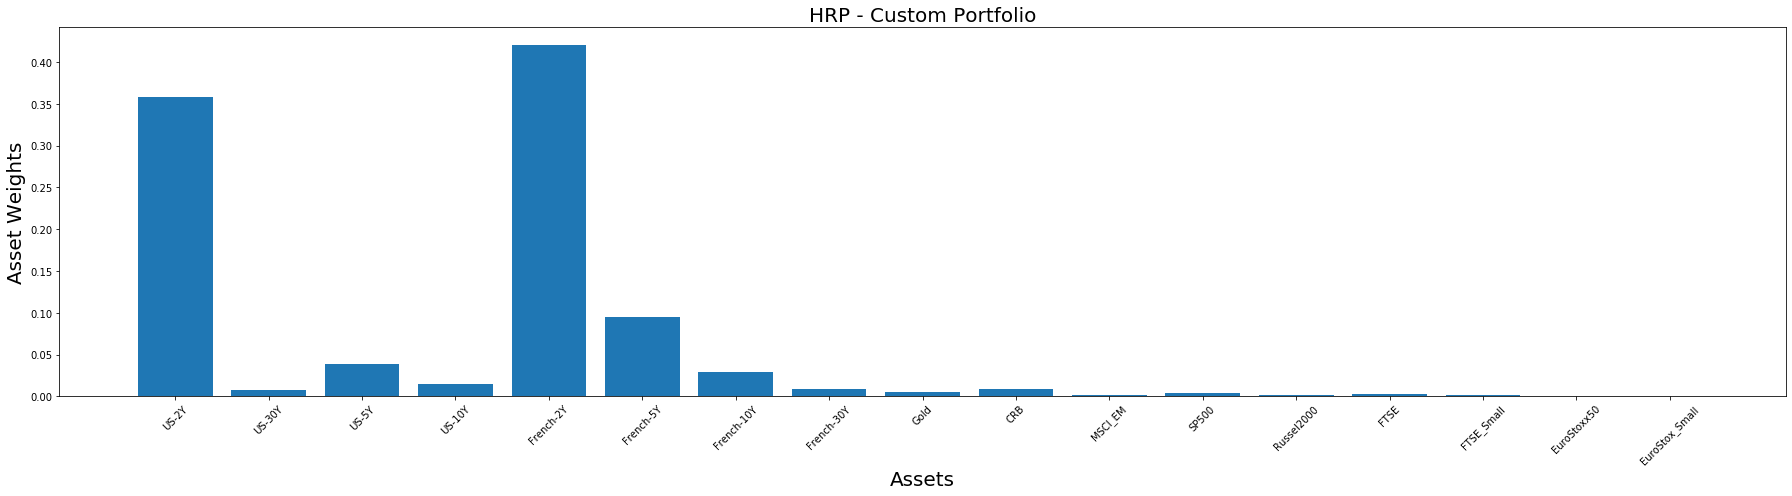

In [14]:
# plotting our optimal portfolio
hrp_custom_weights = hrp_custom.weights
y_pos = np.arange(len(hrp_custom_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_custom_weights.columns), hrp_custom_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Custom Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Custom Portfolio')
plt.show()

As we can see through this example, we can implement the HRP algorithm through MlFInLab very easily to provide high-quality results.

### Using a Custom Distance Matrix
We can also use our own distance matrix to calculate our optimal portfolio. This distance matrix will be derived directly from the covariance matrix.

In [15]:
def cov2corr(covariance):
        """
        Calculate the correlations from asset returns covariance matrix.

        :param covariance: (pd.Dataframe) asset returns covariances
        :return: (pd.Dataframe) correlations between asset returns
        """
        d_matrix = np.zeros_like(covariance)
        diagnoal_sqrt = np.sqrt(np.diag(covariance))
        np.fill_diagonal(d_matrix, diagnoal_sqrt)
        d_inv = np.linalg.inv(d_matrix)
        corr = np.dot(np.dot(d_inv, covariance), d_inv)
        corr = pd.DataFrame(corr, index=covariance.columns, columns=covariance.columns)
        return corr

corr = cov2corr(cov)
distance = np.sqrt((1 - corr).round(5) / 2)

hrp_distance = HierarchicalRiskParity()
hrp_distance.allocate(asset_names=stock_prices.columns,
                      distance_matrix=distance, 
                      covariance_matrix=cov)

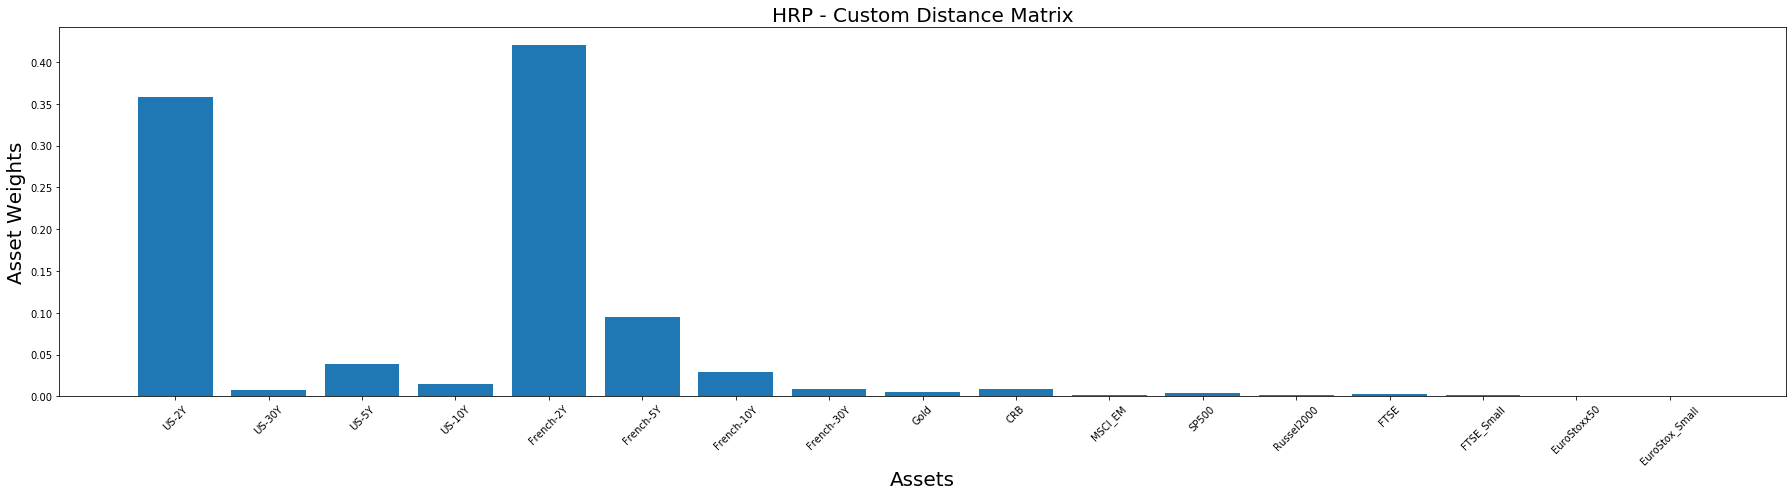

In [16]:
# plotting our optimal portfolio
hrp_distance_weights = hrp_distance.weights
y_pos = np.arange(len(hrp_distance_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_distance_weights.columns), hrp_distance_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Custom Distance Matrix', size=20)
plt.tight_layout()
plt.savefig('HRP Custom Distance Matrix Weights')
plt.show()

### Building our Long/Short Portfolio
In this example, we will construct our Long/Short portfolio utilizing the side_weights parameter. By shorting the first four stocks in our dataset we can construct our optimal portfolio the same way we constructed it earlier, of course with the addition of the side_weight parameter to indicate which stocks we would like to short and long (-1 indicates shorting a stock and 1 indicates going long on a stock).

In [19]:
hrp_ls = HierarchicalRiskParity()
side_weights = pd.Series([1]*stock_prices.shape[1], index=stock_prices.columns)

# short the first 4 stocks
side_weights.loc[stock_prices.columns[:4]] = -1

hrp_ls.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                side_weights=side_weights)

print(side_weights)

FTSE             -1
EuroStoxx50      -1
SP500            -1
Gold             -1
French-2Y         1
French-5Y         1
French-10Y        1
French-30Y        1
US-2Y             1
US-5Y             1
US-10Y            1
US-30Y            1
Russel2000        1
EuroStox_Small    1
FTSE_Small        1
MSCI_EM           1
CRB               1
dtype: int64


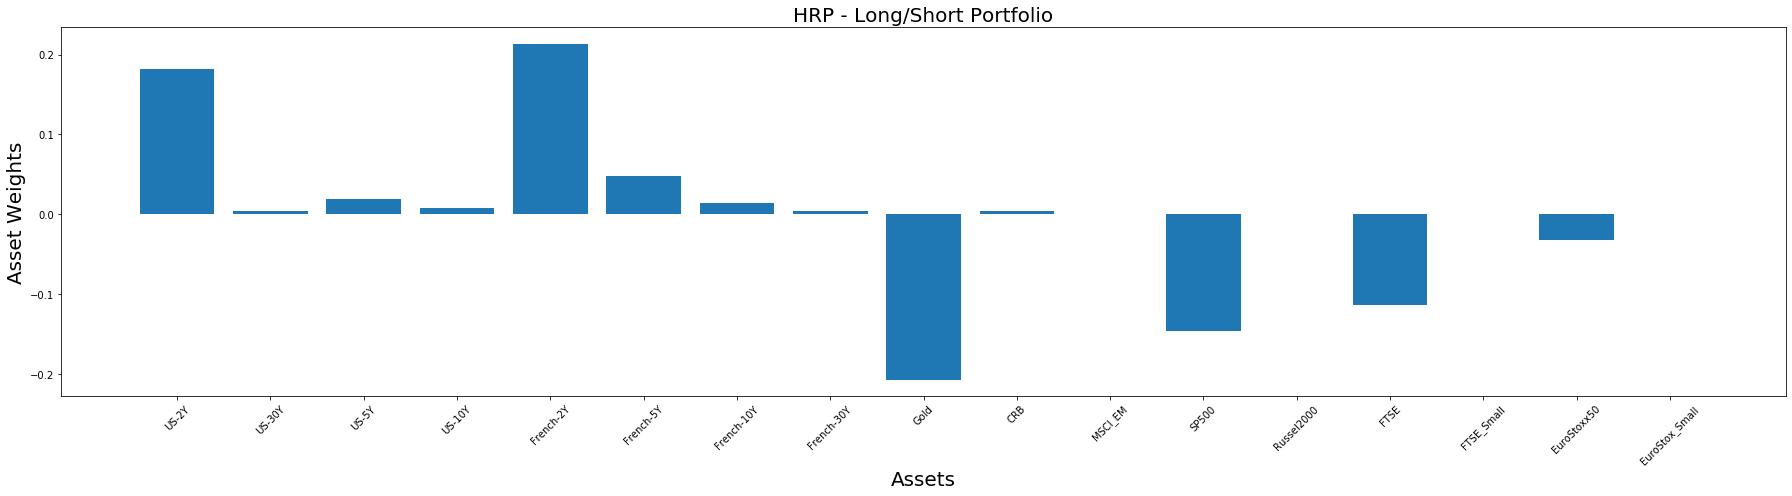

In [23]:
# plotting our optimal portfolio
hrp_ls_weights = hrp_ls.weights
y_pos = np.arange(len(hrp_ls_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hrp_ls_weights.columns), hrp_ls_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('HRP - Long/Short Portfolio', size=20)
plt.tight_layout()
plt.savefig('HRP Long-Short Portfolio')
plt.show()

## Conclusion
Throughout this post, we learned the intuition behind the Hierarchical Risk Parity algorithm and how we can effortlessly apply this technique in custom situations. HRP is a very powerful algorithm which produces robust portfolios that perform much better in live trading than seen with the traditional Modern Portfolio Theory.

If you would like to play around with some of the code in this article, check out our tutorial notebook dedicated to the HRP algorithm! The notebook is stored in Hudson & Thames' research repository on Github under the 'Portfolio Optimisation Tutorials' folder!